# Modeling 

In [103]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 


# statsmodels imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols


# sklearn imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV

# turn off warnings
import warnings
warnings.simplefilter('ignore', category = DeprecationWarning)
warnings.simplefilter('ignore', category = FutureWarning)

# functions from .py file
import src.eda_functions as fun

# plot parameters
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

read in merged_data file

In [4]:
train_set = pd.read_csv('../../data/train_set.csv')
val_set = pd.read_csv('../../data/val_set.csv')
test_set = pd.read_csv('../../data/test_set.csv')

In [5]:
train_set['cohort'] = train_set['cohort'].astype('object')
val_set['cohort'] = val_set['cohort'].astype('object')
test_set['cohort'] = test_set['cohort'].astype('object')

Separate X and y for each set

In [6]:
X_train = train_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_train = train_set.high_school_4_year_graduation_rate_total


X_val = val_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_val = val_set.high_school_4_year_graduation_rate_total

X_test = test_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_test = test_set.high_school_4_year_graduation_rate_total

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 28 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   cohort                                                                      3403 non-null   object 
 1   rcdts                                                                       3403 non-null   object 
 2   school_name                                                                 3403 non-null   object 
 3   district                                                                    3403 non-null   object 
 4   city                                                                        3403 non-null   object 
 5   county                                                                      3403 non-null   object 
 6   district_type                                   

In [8]:
X_test.isnull().sum().sort_values(ascending=False)

student_chronic_truancy_rate                                                  14
student_attendance_rate                                                       12
teacher_retention_rate                                                        12
avg_class_size_high_school                                                     9
total_number_of_school_days                                                    3
high_school_dropout_rate_total                                                 1
city                                                                           0
school_type                                                                    0
district_size                                                                  0
district_type                                                                  0
county                                                                         0
percent_9th_grade_on_track                                                     0
district                    

## Replace NaNs with mean()


Use SimpleImputer to replace NaNs with mean value of respective columns

In [9]:
# identify features
train_num = X_train.select_dtypes(['float64', 'int64'])
val_num = X_val.select_dtypes(['float64', 'int64'])
test_num = X_test.select_dtypes(['float64', 'int64'])

In [10]:
# instatiate imputer
imputer = SimpleImputer(strategy='median')

# fit on the training features
imputer.fit(train_num)

# transform both training data and testing data
train_imp= imputer.transform(train_num)
val_imp = imputer.transform(val_num)
test_imp = imputer.transform(test_num)

# return to DataFrame
X_train_imp = pd.DataFrame(train_imp, columns=train_num.columns, index=X_train.index)
X_val_imp = pd.DataFrame(val_imp, columns=val_num.columns, index=X_val.index)
X_test_imp = pd.DataFrame(test_imp, columns=test_num.columns, index=X_test.index)


# Scaling Numeric features
Using Standard Scaler

In [63]:
# identify features
X_train_num = X_train_imp.select_dtypes(['float64', 'int64'])
X_val_num = X_val_imp.select_dtypes(['float64', 'int64'])
X_test_num = X_test_imp.select_dtypes(['float64', 'int64'])

In [15]:
# instatiate scaler
ss = StandardScaler()

# Train on the training features
ss.fit(X_train_num)

# Transform both training data and testing data
X_train_sc= ss.transform(X_train_num)
X_val_sc = ss.transform(X_val_num)
X_test_sc = ss.transform(X_test_num)


X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_num.columns, index=X_train.index)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_num.columns, index=X_val.index)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_num.columns, index=X_test.index)


# Encoding Categorical features

In [16]:
# identify features
X_train_cat = X_train[['district_type', 'district_size', 'school_type']]
X_val_cat = X_val[['district_type', 'district_size', 'school_type']]
X_test_cat = X_test[['district_type', 'district_size', 'school_type']]

In [78]:
# change these objects to categories
X_train_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')
X_val_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')
X_test_cat.loc[:, ('district_type', 'district_size', 'school_type')].astype('category')

,district_type,district_size,school_type
0,UNIT,MEDIUM,HIGH SCHOOL
1,UNIT,MEDIUM,HIGH SCHOOL
2,UNIT,MEDIUM,HIGH SCHOOL
3,UNIT,MEDIUM,HIGH SCHOOL
4,UNIT,LARGE,HIGH SCHOOL
...,...,...,...
715,UNIT,LARGE,HIGH SCHOOL
716,UNIT,LARGE,HIGH SCHOOL
717,UNIT,LARGE,HIGH SCHOOL
718,HIGH SCHOOL,LARGE,HIGH SCHOOL


In [87]:
X_train_cat.district_type.str.rstrip()
X_train_cat.district_size.str.rstrip()
X_train_cat.school_type.str.rstrip()

0       HIGH SCHOOL
1       HIGH SCHOOL
2       HIGH SCHOOL
3       HIGH SCHOOL
4       HIGH SCHOOL
           ...     
3398    HIGH SCHOOL
3399    HIGH SCHOOL
3400    HIGH SCHOOL
3401    HIGH SCHOOL
3402    HIGH SCHOOL
Name: school_type, Length: 3403, dtype: object

In [82]:
X_val_cat.district_type.str.rstrip()
X_val_cat.district_size.str.rstrip()
X_val_cat.school_type.str.rstrip()

0      HIGH SCHOOL
1      HIGH SCHOOL
2      HIGH SCHOOL
3      HIGH SCHOOL
4      HIGH SCHOOL
          ...     
716    HIGH SCHOOL
717    HIGH SCHOOL
718    HIGH SCHOOL
719    HIGH SCHOOL
720    HIGH SCHOOL
Name: school_type, Length: 721, dtype: object

In [83]:
X_test_cat.district_type.str.rstrip()
X_test_cat.district_size.str.rstrip()
X_test_cat.school_type.str.rstrip()

0      HIGH SCHOOL
1      HIGH SCHOOL
2      HIGH SCHOOL
3      HIGH SCHOOL
4      HIGH SCHOOL
          ...     
715    HIGH SCHOOL
716    HIGH SCHOOL
717    HIGH SCHOOL
718    HIGH SCHOOL
719    HIGH SCHOOL
Name: school_type, Length: 720, dtype: object

In [88]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train_cat)

X_train_ohe = ohe.transform(X_train_cat).toarray()
X_val_ohe = ohe.transform(X_val_cat).toarray()
X_test_ohe = ohe.transform(X_test_cat).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_processed = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train_cat.columns))
X_val_processed = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(X_val_cat.columns))
X_test_processed = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test_cat.columns))

In [93]:
X_train_all = pd.concat([X_train_sc, X_train_processed], axis=1)
X_val_all = pd.concat([X_val_sc, X_val_processed], axis=1)
X_test_all = pd.concat([X_test_sc, X_test_processed], axis=1)


# 6. Test models
- Linear Regression
- Random Forest
- Gradient Boost
- Lasso
- Ridge
- SVM
- KNN

In [108]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_eval(model):
    
    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    model_r2 = r2_score(y_val, model_pred)
    # Return the performance metric
    return model_r2

In [129]:
linreg = LinearRegression()
linreg_r2 = fit_and_eval(linreg)

print('Linear Regression Performance on the validation set: R2 = %0.4f' % linreg_r2)

Linear Regression Performance on the validation set: R2 = 0.4296


In [130]:
random_forest = RandomForestRegressor(random_state=19)
random_forest_r2 = fit_and_eval(random_forest)

print('Random Forest Performance on the validation set: R2 = %0.4f' % random_forest_r2)

Random Forest Performance on the validation set: R2 = 0.4526


In [131]:
extra_trees = ExtraTreesRegressor(random_state=19)
extra_trees_r2 = fit_and_eval(extra_trees)

print('Extra Trees Performance on the validation set: R2 = %0.4f' % extra_trees_r2)

Extra Trees Performance on the validation set: R2 = 0.5548


In [132]:
grad_boost = GradientBoostingRegressor(random_state=19)
grad_boost_r2 = fit_and_eval(grad_boost)

print('Gradient Boosting Performance on the validation set: R2 = %0.4f' % grad_boost_r2)

Gradient Boosting Performance on the validation set: R2 = 0.5584


In [133]:
# Create the model
lasso = Lasso(random_state=19)
lasso_r2 = fit_and_eval(lasso)

print('Lasso model Performance on the validation set: R2 = %0.4f' % lasso_r2)

Lasso model Performance on the validation set: R2 = 0.4901


In [134]:
ridge = Ridge(random_state=19)
ridge_r2 = fit_and_eval(ridge)

print('Ridge Model Performance on the validation set: R2 = %0.4f' % ridge_r2)

Ridge Model Performance on the validation set: R2 = 0.5313


In [135]:
svr = SVR()
svr_r2 = fit_and_eval(svr)

print('Support Vector Machine Regression Performance on the validation set: R2 = %0.4f' % svr_r2)

Support Vector Machine Regression Performance on the validation set: R2 = 0.3937


In [136]:
knn = KNeighborsRegressor()
knn_r2 = fit_and_eval(knn)

print('K-Nearest Neighbors Regression Performance on the validation set: R2 = %0.4f' % knn_r2)

K-Nearest Neighbors Regression Performance on the validation set: R2 = 0.4970


# Select best performing model

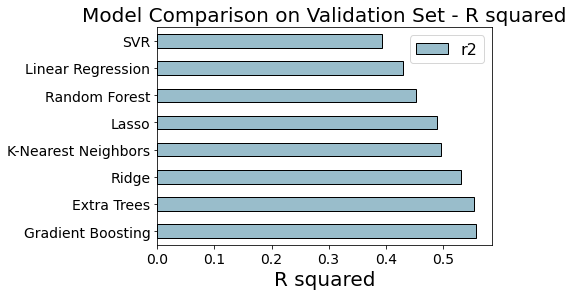

In [137]:
# Dataframe to hold the results
           
model_comparison = pd.DataFrame({'model': ['Linear Regression','Random Forest',
                                           'Extra Trees','Gradient Boosting',
                                           'Lasso', 'Ridge', 'SVR','K-Nearest Neighbors'],
                                 'r2': [linreg_r2, random_forest_r2, extra_trees_r2, 
                                         grad_boost_r2, lasso_r2, ridge_r2, svr_r2, knn_r2]})

# Horizontal bar chart of test r2
model_comparison.sort_values('r2', ascending = False).plot(x = 'model', y = 'r2', kind = 'barh',
                                                           color = '#99BDCB', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('R squared'); plt.xticks(size = 14)
plt.title('Model Comparison on Validation Set - R squared', size = 20);

#### Results: 
##### Gradient Boosting Regressor returns the highest R-squared value at 0.5584.

##### Extra Trees is a close second at 0.5548.

I will tune hyperparameters for each these models, then compare the results of that head-to-head to come decide on a final model.

# Tune hyperparamters with Randomized Search CV

In [145]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

#### Check out Gradient Boosting best model

In [153]:
# Create the model to use for hyperparameter tuning
model_1 = GradientBoostingRegressor(random_state = 19)

# Set up the random search with 4-fold cross validation
random_cv_1 = RandomizedSearchCV(estimator=model_1,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'r2',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [154]:
# Fit on the training data
random_cv_1.fit(X_train_all, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [155]:
# Find the best combination of settings
random_cv_1.best_estimator_


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### Evaluate model_1 - Gradient Boosting

In [161]:
model_1 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


model_1_r2 = fit_and_eval(model_1)

print('Model_1 Performance on the validation set: R2 = %0.4f' % model_1_r2)

Model_1 Performance on the validation set: R2 = 0.5914


#### Check out Extra Trees best model

In [160]:
# create the model to use for hyperparameter tuning
model_2 = ExtraTreesRegressor(random_state = 19)

# set up the random search with 4-fold cross validation
random_cv_2 = RandomizedSearchCV(estimator=model_2,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'r2',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [158]:
# fit on the training data
random_cv_2.fit(X_train_all, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=ExtraTreesRegressor(bootstrap=False,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators='warn',
                                                 n_jobs=None, oob_score=False,
                                                 random_stat..., verbose=0,
            

In [159]:
# find the best combination of settings
random_cv_2.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features=None, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=8, min_samples_split=4,
                    min_weight_fraction_leaf=0.0, n_estimators=1500,
                    n_jobs=None, oob_score=False, random_state=19, verbose=0,
                    warm_start=False)

In [162]:
model_2 = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features=None, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=8, min_samples_split=4,
                    min_weight_fraction_leaf=0.0, n_estimators=1500,
                    n_jobs=None, oob_score=False, random_state=19, verbose=0,
                    warm_start=False)


model_2_r2 = fit_and_eval(model_2)

print('Model Performance on the validation set: R2 = %0.4f' % model_2_r2)

Final Model Performance on the validation set: R2 = 0.6001


In [164]:
print('Model_1 Performance on the validation set: R2 = %0.4f' % model_1_r2)
print('Model_2 Performance on the validation set: R2 = %0.4f' % model_2_r2)

Model_1 Performance on the validation set: R2 = 0.5914
Model_2 Performance on the validation set: R2 = 0.6001


### Final result: Extra Trees just edges out Gradient Boosting.
I'm glad I tuend and compared them head-to-head

# Evaluate on test set

In [168]:
# Select the best model
final_model = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
                    max_features=None, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=8, min_samples_split=4,
                    min_weight_fraction_leaf=0.0, n_estimators=1500,
                    n_jobs=None, oob_score=False, random_state=19, verbose=0,
                    warm_start=False)

# Make predictions on the test set using final model
final_model.fit(X_train_all, y_train)
final_pred = final_model.predict(X_test_all)
final_r2 = r2_score(y_test, final_pred)

print('Final Model Performance on the test set: R2 = %0.4f' % final_model_r2)

Final Model Performance on the test set: R2 = 0.5914


# Final model performance has an R-squared score of 0.5914.

That is not as high as I had hoped, but for comparison:
- My First Simple Model (OLS Linear Regression) had an R-squared score of 0.445
- The Extra Trees model in it's default state  had a score of 0.5548.
- The hypertuned Extra Trees model had a score of 0.6001.

So, the model did improve by approximately 15 percentage points.
The consistency of the final validation score and the test set score suggest that the is neither overfit nor underfit... which is a good result.

# Model interpretation
- feature importances
- plot single decision tree


In [169]:
feature_results = pd.DataFrame({'feature': list(X_train_all.columns), 
                                'importance': final_model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,high_school_5_year_graduation_rate_total,0.413822
1,high_school_dropout_rate_total,0.209835
2,student_chronic_truancy_rate,0.088068
3,student_attendance_rate,0.086662
4,percent_9th_grade_on_track,0.034700
5,school_type_HIGH SCHOOL,0.028559
6,percent_student_enrollment_white,0.026367
7,total_number_of_school_days,0.016520
8,percent_student_enrollment_black_or_african_am...,0.015335
9,avg_class_size_high_school,0.011342


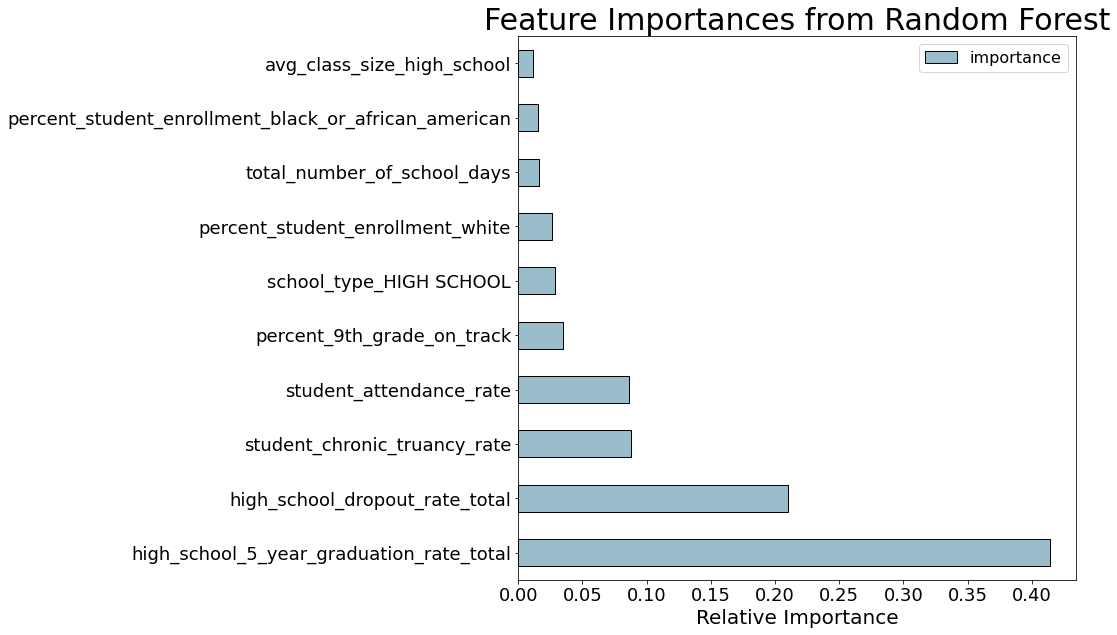

In [173]:
# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = '#99BDCB');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);